### Améliorez un jeu de données

- Ce qui est formidable avec ce dataset, hormis de pouvoir visualiser tous les arbres d'une ville comme Paris, c'est qu'il illustre parfaitement les principaux problèmes qu'un data scientist rencontre :

    - des données manquantes ;

    - des données aberrantes (outliers) ;

    - des catégories trop nombreuses ou sous-représentées.

In [44]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as plt

In [45]:
df = pd.read_csv("les-arbres.csv")
df.head()

C:\Users\nbous\AppData\Local\Temp\ipykernel_15344\1757737780.py:1: DtypeWarning: Columns (0,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("les-arbres.csv")


,idbase,domanialite,arrondissement,complement_adresse,numero,lieu_adresse,idemplacement,libelle_francais,genre,espece,variete_oucultivar,circonference_cm,hauteur_m,stade_de_developpement,remarquable,geo_point_2d
0,256032,Alignement,PARIS 14E ARRDT,NaN,NaN,RUE VERCINGETORIX,000602025,Erable,Acer,pseudoplatanus,''Atropurpureum'',70.0,6.0,Jeune (arbre),NON,"48.83154687478726, 2.3093726893065596"
1,281618,Alignement,PARIS 8E ARRDT,NaN,NaN,AVENUE DES CHAMPS ELYSEES,000305044,Marronnier,Aesculus,hippocastanum,''Baumannii'',20.0,4.0,Jeune (arbre),NON,"48.86665704304558, 2.3162802812024443"
2,302647,Jardin,PARIS 8E ARRDT,Secteur Kiosque,NaN,JARDINS DES CHAMPS ELYSEES - ABORDS DU KIOSQUE...,000109003,If,Taxus,baccata,NaN,50.0,5.0,Jeune (arbre)Adulte,NON,"48.86594098488487, 2.3177825326579695"
3,238226,Alignement,PARIS 12E ARRDT,37,NaN,AVENUE DE SAINT MANDE,000501020,Platane,Platanus,x hispanica,NaN,30.0,5.0,Jeune (arbre),NON,"48.84515461889761, 2.4008303350818525"
4,110978,Jardin,PARIS 19E ARRDT,NaN,NaN,PARC DES BUTTES CHAUMONT,K69K0040,Pin,Pinus,nigra,NaN,100.0,10.0,NaN,NaN,"48.87971709048107, 2.3797109748696337"


In [46]:
df = df[df.libelle_francais == 'Platane'].copy()
df.head(3)

,idbase,domanialite,arrondissement,complement_adresse,numero,lieu_adresse,idemplacement,libelle_francais,genre,espece,variete_oucultivar,circonference_cm,hauteur_m,stade_de_developpement,remarquable,geo_point_2d
3,238226,Alignement,PARIS 12E ARRDT,37,NaN,AVENUE DE SAINT MANDE,000501020,Platane,Platanus,x hispanica,NaN,30.0,5.0,Jeune (arbre),NON,"48.84515461889761, 2.4008303350818525"
9,289464,Alignement,PARIS 12E ARRDT,NaN,NaN,AVENUE LEDRU ROLLIN,000402007,Platane,Platanus,x hispanica,NaN,60.0,10.0,Adulte,NON,"48.84717970255216, 2.37017013054543"
10,221701,Alignement,PARIS 16E ARRDT,NaN,NaN,BOULEVARD DE L AMIRAL BRUIX,000705007,Platane,Platanus,x hispanica,NaN,68.0,10.0,Jeune (arbre)Adulte,NON,"48.87428152523608, 2.2783797113253454"


In [47]:
df.isnull().sum()


idbase                        0
domanialite                   0
arrondissement                0
complement_adresse        27279
numero                    42588
lieu_adresse                  0
idemplacement                 0
libelle_francais              0
genre                         0
espece                        4
variete_oucultivar        42328
circonference_cm              0
hauteur_m                     0
stade_de_developpement     3350
remarquable                1236
geo_point_2d                  0
dtype: int64

In [48]:
# Compter les valeurs manquantes par stade_de_developpement
missing_values_by_stade = df.groupby('stade_de_developpement')['stade_de_developpement'].apply(lambda x: len(x.values))

missing_values_by_stade

stade_de_developpement
Adulte                 21620
Jeune (arbre)           5916
Jeune (arbre)Adulte     8356
Mature                  3346
Name: stade_de_developpement, dtype: int64

In [49]:
# Calculer le nombre total de NAN dans la colonne stade_de_developpement
total_nan = df['stade_de_developpement'].isnull().sum()

# Créer un DataFrame pour stocker les comptages par catégorie de stade_de_developpement
comptages_par_stade = df.groupby('stade_de_developpement').size().reset_index(name='compte')

# Créer un DataFrame pour les valeurs manquantes
nan_df = pd.DataFrame([{'stade_de_developpement': 'NAN', 'compte': total_nan}])

# Concaténer les deux DataFrames
comptages_par_stade = pd.concat([comptages_par_stade, nan_df], ignore_index=True)

# Afficher le DataFrame avec le compte des NAN
print(comptages_par_stade)


  stade_de_developpement  compte
0                 Adulte   21620
1          Jeune (arbre)    5916
2    Jeune (arbre)Adulte    8356
3                 Mature    3346
4                    NAN    3350


On suppose que la valeur  Jeune (arbre)Adulte  n'est pas une erreur de saisie mais plutôt une valeur intermédiaire entre les catégories  Jeune (arbre)  et  Adulte  . On a donc la graduation :  Jeune (arbre)  , Jeune (arbre)Adulte, Adultepuis  Mature  .

    - À ce stade on peut choisir de simplement supprimer tous les échantillons pour lesquels la valeur  stade_de_developpement  est absente. Cela ne concerne que 7,8 % des données.

    - On peut aussi essayer de remédier aux valeurs manquantes en observant la relation entre les mesures des arbres et leur stade de développement. 
    
    - Notre hypothèse est que les arbres  Jeune  ou  Mature  sont nettement plus petits que les arbres  Adulte  .

Le boxplot montre la répartition de la hauteur et de la circonférence par stade de développement.

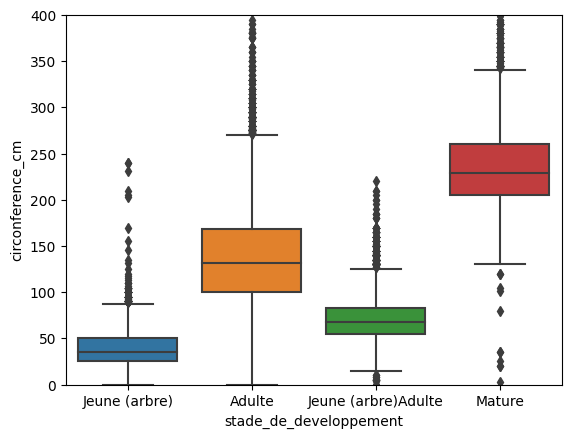

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# Créer le boxplot
sns.boxplot(data=df, y="circonference_cm", x="stade_de_developpement")

# Spécifier les limites de l'axe y (circonference_cm)
plt.ylim(bottom=0, top=400)  # Tu peux ajuster les limites selon tes besoins

# Afficher le graphique
plt.show()


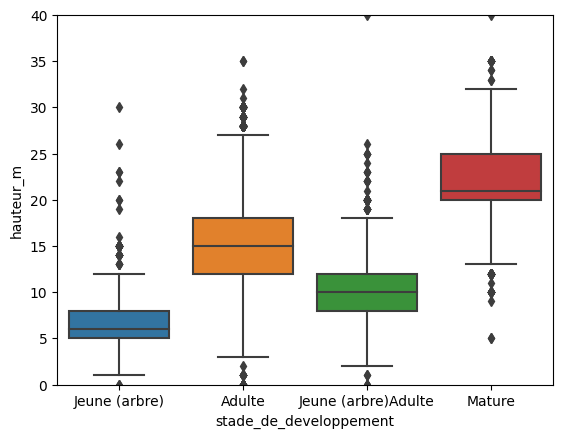

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# Créer le boxplot
sns.boxplot(data=df, y="hauteur_m", x="stade_de_developpement")

# Spécifier les limites de l'axe y (circonference_cm)
plt.ylim(bottom=0, top=40)  # Tu peux ajuster les limites selon tes besoins

# Afficher le graphique
plt.show()


Outliers